# Batting Statistics Analysis

This notebook provides comprehensive analysis of batting statistics using the BaseballDataLoader. We focus on modern analytics that prioritize meaningful stats over traditional metrics.

## Key Statistics Explained
- **AVG (Batting Average)**: Hits per at-bat - traditional but limited metric
- **OBP (On-Base Percentage)**: Rate of reaching base safely - more valuable than AVG
- **OPS (On-Base Plus Slugging)**: Combined measure of getting on base and hitting for power
- **wRC+ (Weighted Runs Created Plus)**: Context-adjusted offensive value (100 = league average)
- **ISO (Isolated Power)**: Measure of raw power (SLG - AVG)
- **K-BB% (Strikeout minus Walk Rate)**: Plate discipline indicator

In [35]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# Import baseball stats data loader
# Import our baseball analytics functions
from src.baseball_stats import BaseballDataLoader

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

In [36]:
# Configure global logging level to INFO
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Set root logger to INFO to suppress DEBUG logs from all libraries
logging.getLogger().setLevel(logging.INFO)

In [37]:
# Initialize data loader with 2025 data and qualified thresholds
print("Loading 2025 batting data for qualified hitters (100+ PA)...")
loader = BaseballDataLoader(year=2025, min_pa=100, min_ip=20)
loader.load_all()

# Get hitting data - try multiple methods to ensure we get data
hitting_data = None
try:
    # Try qualified hitters first
    hitting_data = loader.hitting_qualified
    print(f"Loaded qualified hitting data: {len(hitting_data)} players")
except Exception as e:
    print(f"Error loading qualified data: {e}")
    try:
        # Fallback to raw data
        hitting_data = loader.hitting_raw
        # Filter for qualified hitters manually
        if 'PA' in hitting_data.columns:
            hitting_data = hitting_data[hitting_data['PA'] >= 100]
        print(f"Loaded raw hitting data (filtered): {len(hitting_data)} players")
    except Exception as e2:
        print(f"Error loading raw data: {e2}")
        # Try FanGraphs data as last resort
        try:
            hitting_data = loader.hitting_fangraphs
            if hitting_data is not None:
                print(f"Loaded FanGraphs hitting data: {len(hitting_data)} players")
            else:
                print("No hitting data available")
        except Exception as e3:
            print(f"Error loading FanGraphs data: {e3}")

if hitting_data is not None and not hitting_data.empty:
    print(f"Final dataset: {len(hitting_data)} qualified hitters")
    print(f"Available columns: {list(hitting_data.columns)[:10]}...")  # Show first 10 columns
    print(f"Total columns: {len(hitting_data.columns)}")
else:
    print("⚠️ No hitting data could be loaded. This might be due to network issues or data availability.")

Loading 2025 batting data for qualified hitters (100+ PA)...
🚀 Loading all baseball data for 2025...
📊 Loading hitting data...
Fetching baserunning metrics for 2025...
Error getting baserunning data: 'module' object is not callable
⚾ Loading pitching data...
🏟️ Loading team data...
📡 Loading Statcast data...
🧤 Loading fielding data...
Fetching fielding metrics for 2025...
Error getting fielding data: 'module' object is not callable
✅ All data loaded successfully!

📊 Data Summary:
Year: 2025

Hitting Data:
  - raw: 158 records
  - qualified: 158 records
  - fangraphs: 361 records
  - sprint_speed: 493 records

Pitching Data:
  - raw: 71 records
  - qualified: 71 records
  - fangraphs: 405 records

Team Data:
  - stats: loaded
  - standings: loaded

Statcast Data:
  - recent: 117377 records
  - bat_tracking: 54693 records
Loaded qualified hitting data: 158 players
Final dataset: 158 qualified hitters
Available columns: ['IDfg', 'Season', 'Name', 'Team', 'Age', 'G', 'AB', 'PA', 'H', '1B']

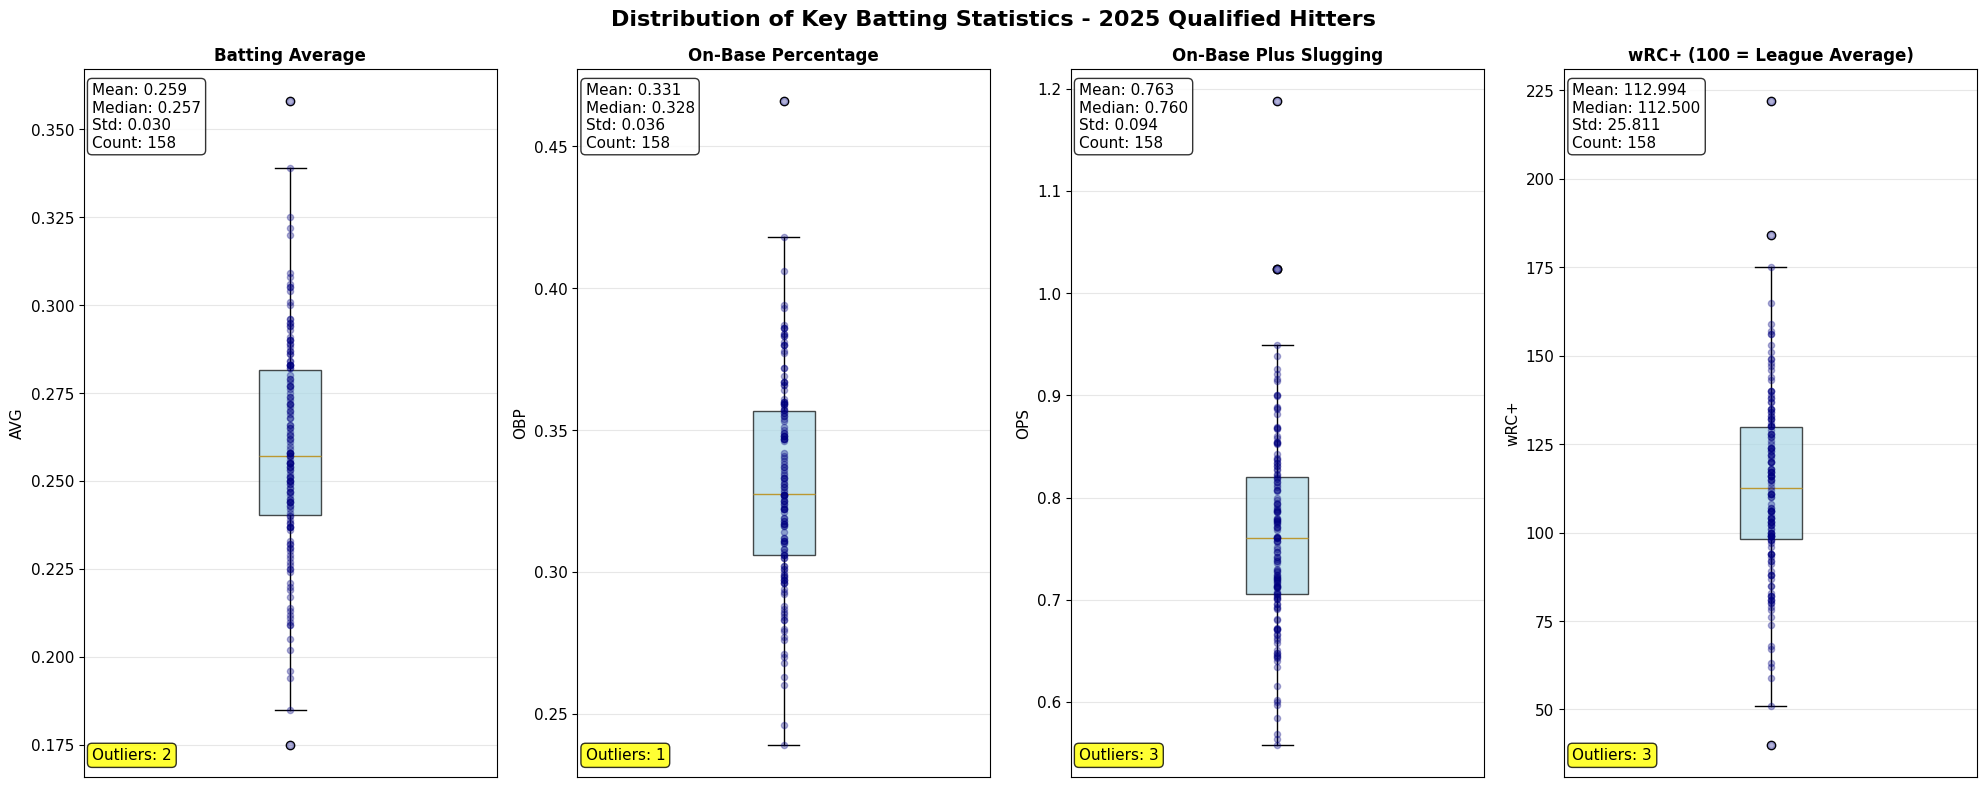

In [38]:
# Create horizontal box plots for distribution analysis
if hitting_data is not None and not hitting_data.empty:
    # Define the statistics to plot
    stats_to_plot = [
        ('AVG', 'Batting Average'),
        ('OBP', 'On-Base Percentage'),
        ('OPS', 'On-Base Plus Slugging'),
        ('wRC+', 'wRC+ (100 = League Average)')
    ]
    
    # Filter to only include available statistics
    available_stats = [(stat, title) for stat, title in stats_to_plot if stat in hitting_data.columns]
    
    if available_stats:
        fig, axes = plt.subplots(1, len(available_stats), figsize=(5*len(available_stats), 8))
        fig.suptitle('Distribution of Key Batting Statistics - 2025 Qualified Hitters', fontsize=16, fontweight='bold')
        
        # Handle case where there's only one plot
        if len(available_stats) == 1:
            axes = [axes]
        
        # Create box plots for each statistic
        for i, (stat, title) in enumerate(available_stats):
            ax = axes[i]
            
            # Clean data
            data_clean = hitting_data[stat].dropna()
            
            if len(data_clean) > 0:
                # Create box plot
                bp = ax.boxplot(data_clean, patch_artist=True, vert=True)
                
                # Color the box plot
                bp['boxes'][0].set_facecolor('lightblue')
                bp['boxes'][0].set_alpha(0.7)
                
                # Add scatter plot of actual data points
                y_data = data_clean.values
                x_data = [1] * len(y_data)  # All points at x=1
                ax.scatter(x_data, y_data, alpha=0.3, color='navy', s=20, zorder=3)
                
                # Formatting
                ax.set_title(title, fontweight='bold', fontsize=12)
                ax.set_ylabel(stat, fontsize=11)
                ax.grid(True, alpha=0.3)
                ax.set_xticks([])  # Remove x-axis ticks since we only have one box
                
                # Add summary statistics as text
                stats_text = f'Mean: {data_clean.mean():.3f}\nMedian: {data_clean.median():.3f}\nStd: {data_clean.std():.3f}\nCount: {len(data_clean)}'
                ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                # Highlight outliers
                Q1 = data_clean.quantile(0.25)
                Q3 = data_clean.quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outliers = data_clean[(data_clean < lower_bound) | (data_clean > upper_bound)]
                if len(outliers) > 0:
                    ax.text(0.02, 0.02, f'Outliers: {len(outliers)}', transform=ax.transAxes, 
                            verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
            else:
                ax.text(0.5, 0.5, f'{stat} has no valid data', 
                        transform=ax.transAxes, ha='center', va='center')
                ax.set_title(title, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ None of the standard statistics (AVG, OBP, OPS, wRC+) are available in the dataset")
        print("Available columns:", list(hitting_data.columns)[:10])
else:
    print("⚠️ Cannot create distribution plots - no hitting data available")

In [40]:
# Display summary statistics for key metrics
if hitting_data is not None and not hitting_data.empty:
    print("\\n=== BATTING STATISTICS SUMMARY (2025 Qualified Hitters) ===")
    print("\\nKey Statistics Overview:")
    
    # Calculate summary stats for available metrics
    summary_stats = ['AVG', 'OBP', 'OPS', 'wRC+', 'ISO', 'BB%', 'K%', 'SLG', 'wOBA', 'BABIP']
    available_stats = [stat for stat in summary_stats if stat in hitting_data.columns]
    
    if available_stats:
        summary_df = hitting_data[available_stats].describe()
        display(summary_df.round(3))
        
        print(f"\\n📊 Summary: Found {len(available_stats)} key statistics for {len(hitting_data)} players")
        print(f"Available stats: {', '.join(available_stats)}")
    else:
        print("Standard statistics not found. Available columns:")
        print(list(hitting_data.columns)[:20])  # Show first 20 columns
        print(f"\\nTotal columns available: {len(hitting_data.columns)}")
else:
    print("⚠️ Cannot display summary statistics - no hitting data available")

\n=== BATTING STATISTICS SUMMARY (2025 Qualified Hitters) ===
\nKey Statistics Overview:


,AVG,OBP,OPS,wRC+,ISO,BB%,K%,SLG,wOBA,BABIP
count,158.000,158.000,158.000,158.000,158.000,158.000,158.000,158.000,158.000,158.000
mean,0.259,0.331,0.763,112.994,0.173,0.090,0.208,0.432,0.333,0.300
std,0.030,0.036,0.094,25.811,0.057,0.032,0.059,0.069,0.036,0.037
min,0.175,0.239,0.558,40.000,0.041,0.025,0.021,0.298,0.244,0.199
25%,0.240,0.306,0.706,98.250,0.133,0.066,0.167,0.387,0.310,0.275
50%,0.257,0.328,0.760,112.500,0.167,0.085,0.210,0.422,0.334,0.298
75%,0.282,0.357,0.820,129.750,0.209,0.110,0.251,0.474,0.355,0.323
max,0.358,0.466,1.188,222.000,0.369,0.183,0.387,0.722,0.486,0.439


\n📊 Summary: Found 10 key statistics for 158 players
Available stats: AVG, OBP, OPS, wRC+, ISO, BB%, K%, SLG, wOBA, BABIP


## Section 2: Single Player Investigation

Let's dive deep into a single player's complete batting profile. We'll examine both traditional and modern metrics to get a comprehensive view of their offensive performance.

### Player Selection
We'll analyze a notable player's 2025 performance, showcasing both traditional stats and advanced analytics.

In [41]:
# Select a notable player for analysis
if hitting_data is not None and not hitting_data.empty:
    print("Top 10 hitters by available offensive metrics:")
    print("\\n=== Available Columns ===")
    print(f"Total columns: {len(hitting_data.columns)}")
    print("First 20 columns:", list(hitting_data.columns)[:20])
    
    # Try to identify a good sorting column
    sort_candidates = ['wRC+', 'OPS', 'wOBA', 'WAR', 'SLG']
    sort_column = None
    for candidate in sort_candidates:
        if candidate in hitting_data.columns:
            sort_column = candidate
            break
    
    if sort_column:
        print(f"\\nTop 10 players by {sort_column}:")
        # Clean data before sorting
        clean_data = hitting_data.dropna(subset=[sort_column])
        if len(clean_data) > 0:
            top_players = clean_data.nlargest(10, sort_column)
            
            # Find name column
            name_cols = [col for col in hitting_data.columns if 'name' in col.lower() or col in ['Name', 'Player', 'player_name']]
            display_cols = name_cols[:1] if name_cols else []
            display_cols.extend([col for col in ['AVG', 'OBP', 'OPS', 'SLG', sort_column] if col in hitting_data.columns])
            
            if display_cols:
                display(top_players[display_cols])
            else:
                print("Player names not available in standard format")
                display(top_players.head())
        else:
            print(f"No valid data for {sort_column}")
    else:
        print("\\nStandard sorting columns not found. Showing first few players:")
        display(hitting_data.head())
else:
    print("⚠️ Cannot display top players - no hitting data available")

Top 10 hitters by available offensive metrics:
\n=== Available Columns ===
Total columns: 320
First 20 columns: ['IDfg', 'Season', 'Name', 'Team', 'Age', 'G', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF']
\nTop 10 players by wRC+:


,Name,AVG,OBP,OPS,SLG,wRC+
0,Aaron Judge,0.358,0.466,1.188,0.722,222
2,Cal Raleigh,0.272,0.383,1.024,0.641,184
1,Shohei Ohtani,0.287,0.387,1.024,0.637,175
3,Will Smith,0.320,0.418,0.949,0.532,165
5,Pete Alonso,0.291,0.380,0.921,0.541,159
8,Jonathan Aranda,0.325,0.406,0.899,0.493,157
6,Kyle Tucker,0.290,0.393,0.926,0.533,156
4,James Wood,0.283,0.386,0.938,0.552,156
10,Juan Soto,0.258,0.394,0.900,0.507,153
7,Kyle Schwarber,0.250,0.384,0.916,0.532,151


In [48]:
# Select a specific player for detailed analysis
if hitting_data is not None and not hitting_data.empty:
    target_player = None
    
    # Find name column
    name_column = None
    for col in hitting_data.columns:
        if 'name' in col.lower() or col in ['Name', 'Player', 'player_name']:
            name_column = col
            break
    
    if name_column:
        print(f"Found name column: {name_column}")
        
        # Prompt user for player selection
        print("\n🎯 PLAYER SELECTION")
        print("=" * 30)
        print("Enter a player name to analyze, or type 'random' for a random selection:")
        print("Examples: 'Aaron Judge', 'Juan Soto', 'Mookie Betts', 'random'")
        
        # Get user input
        user_input = input("\nEnter player name (or 'random'): ").strip()
        
        if user_input.lower() == 'random':
            # Select random player
            import random
            random_index = random.randint(0, len(hitting_data) - 1)
            target_player = hitting_data.iloc[random_index]
            print(f"🎲 Randomly selected: {target_player[name_column]}")
        else:
            # Search for specific player
            print(f"🔍 Searching for: {user_input}")
            
            # Try exact match first
            exact_matches = hitting_data[hitting_data[name_column].str.contains(user_input, na=False, case=False)]
            
            if len(exact_matches) > 0:
                if len(exact_matches) == 1:
                    target_player = exact_matches.iloc[0]
                    print(f"✅ Found exact match: {target_player[name_column]}")
                else:
                    print(f"📋 Found {len(exact_matches)} matches:")
                    for i, (_, player) in enumerate(exact_matches.head(10).iterrows()):
                        print(f"  {i+1}. {player[name_column]}")
                    
                    # Use first match
                    target_player = exact_matches.iloc[0]
                    print(f"🎯 Using first match: {target_player[name_column]}")
            else:
                # Try partial match with last name
                if ' ' in user_input:
                    last_name = user_input.split()[-1]
                    print(f"🔍 Trying last name search: {last_name}")
                    partial_matches = hitting_data[hitting_data[name_column].str.contains(last_name, na=False, case=False)]
                    
                    if len(partial_matches) > 0:
                        target_player = partial_matches.iloc[0]
                        print(f"✅ Found partial match: {target_player[name_column]}")
                    else:
                        print(f"❌ No matches found for '{user_input}'")
                else:
                    print(f"❌ No matches found for '{user_input}'")
    else:
        print("⚠️ Name column not found in dataset")
    
    # If no player found, fall back to top performer
    if target_player is None:
        print("\n🔄 Falling back to top performer...")
        if 'wRC+' in hitting_data.columns:
            clean_data = hitting_data.dropna(subset=['wRC+'])
            if len(clean_data) > 0:
                target_player = clean_data.loc[clean_data['wRC+'].idxmax()]
                player_name_display = target_player.get(name_column, 'Unknown Player') if name_column else 'Top Performer'
                print(f"📊 Using top performer by wRC+: {player_name_display}")
            else:
                target_player = hitting_data.iloc[0]
                print("Using first player in dataset")
        else:
            target_player = hitting_data.iloc[0]
            print("Using first player in dataset")
    
    if target_player is not None:
        player_name_display = target_player.get(name_column, 'Unknown Player') if name_column else 'Player (name not available)'
        print(f"\n🎯 Selected player for analysis: {player_name_display}")
        print("=" * 50)
    else:
        print("⚠️ Could not select a player for analysis")
else:
    print("⚠️ Cannot select player - no hitting data available")
    target_player = None
    name_column = None

Found name column: Name

🎯 PLAYER SELECTION
Enter a player name to analyze, or type 'random' for a random selection:
Examples: 'Aaron Judge', 'Juan Soto', 'Mookie Betts', 'random'
🔍 Searching for: Kyle Tucker
✅ Found exact match: Kyle Tucker

🎯 Selected player for analysis: Kyle Tucker


In [49]:
# Create a DataFrame view of the player's key statistics
if target_player is not None:
    print("\\n📋 PLAYER STATISTICS TABLE")
    print("=" * 40)
    
    # Select key statistics for table display
    key_stats = ['AVG', 'OBP', 'SLG', 'OPS', 'wRC+', 'HR', 'RBI', 'R', 'BB%', 'K%', 'ISO', 'BABIP', 'wOBA']
    available_key_stats = [stat for stat in key_stats if stat in target_player.index and pd.notna(target_player[stat])]
    
    if available_key_stats:
        # Create a formatted table
        player_stats_df = pd.DataFrame({
            'Statistic': available_key_stats,
            'Value': [target_player[stat] for stat in available_key_stats]
        })
        
        # Round values appropriately
        player_stats_df['Value'] = player_stats_df.apply(
            lambda row: f"{row['Value']:.3f}" if row['Statistic'] in ['AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'wOBA'] 
            else f"{row['Value']:.1f}" if row['Statistic'] in ['BB%', 'K%'] 
            else f"{row['Value']:.0f}", axis=1
        )
        
        display(player_stats_df)
    else:
        print("Key statistics not available in expected format")
        print("Available stats for this player:")
        # Show all available stats
        non_null_stats = target_player.dropna()
        print(f"Found {len(non_null_stats)} non-null statistics")
        if len(non_null_stats) > 0:
            stats_df = pd.DataFrame({'Statistic': non_null_stats.index, 'Value': non_null_stats.values})
            display(stats_df.head(20))
else:
    print("⚠️ Cannot create statistics table - no player selected")

\n📋 PLAYER STATISTICS TABLE


,Statistic,Value
0,AVG,0.290
1,OBP,0.393
2,SLG,0.533
3,OPS,0.926
4,wRC+,156
5,HR,17
6,RBI,52
7,R,61
8,BB%,0.1
9,K%,0.1


In [50]:
# Performance Context - How does this player compare to league average?
if target_player is not None and hitting_data is not None and not hitting_data.empty:
    print("\\n🏆 PERFORMANCE CONTEXT")
    print("=" * 40)
    
    # Compare key metrics to league average
    comparison_stats = ['AVG', 'OBP', 'OPS', 'wRC+', 'HR', 'BB%', 'K%']
    available_comparison = [stat for stat in comparison_stats if stat in hitting_data.columns]
    
    if available_comparison:
        print("Player vs. League Average (2025 Qualified Hitters):\\n")
        
        comparison_data = []
        for stat in available_comparison:
            if stat in target_player.index and pd.notna(target_player[stat]):
                player_value = target_player[stat]
                league_data = hitting_data[stat].dropna()
                
                if len(league_data) > 0:
                    league_avg = league_data.mean()
                    league_std = league_data.std()
                    
                    # Calculate percentile
                    percentile = (league_data <= player_value).mean() * 100
                    
                    # Calculate z-score
                    z_score = (player_value - league_avg) / league_std if league_std > 0 else 0
                    
                    comparison_data.append({
                        'Statistic': stat,
                        'Player': f"{player_value:.3f}" if stat in ['AVG', 'OBP', 'OPS'] else f"{player_value:.1f}",
                        'League Avg': f"{league_avg:.3f}" if stat in ['AVG', 'OBP', 'OPS'] else f"{league_avg:.1f}",
                        'Percentile': f"{percentile:.1f}%",
                        'Z-Score': f"{z_score:.2f}"
                    })
        
        if comparison_data:
            comparison_df = pd.DataFrame(comparison_data)
            display(comparison_df)
            
            # Performance summary
            print("\\n📈 PERFORMANCE SUMMARY")
            print("-" * 25)
            
            # Check if player has standout metrics
            elite_stats = []
            above_avg_stats = []
            
            for _, row in comparison_df.iterrows():
                try:
                    percentile = float(row['Percentile'].replace('%', ''))
                    if percentile >= 90:
                        elite_stats.append(row['Statistic'])
                    elif percentile >= 60:
                        above_avg_stats.append(row['Statistic'])
                except:
                    continue
            
            if elite_stats:
                print(f"🌟 Elite Performance (90th+ percentile): {', '.join(elite_stats)}")
            if above_avg_stats:
                print(f"✅ Above Average (60th+ percentile): {', '.join(above_avg_stats)}")
            
            # Overall assessment
            if 'wRC+' in target_player.index and pd.notna(target_player['wRC+']):
                wrc_plus = target_player['wRC+']
                if wrc_plus >= 130:
                    print(f"🏆 Overall Rating: Elite hitter (wRC+ = {wrc_plus:.0f})")
                elif wrc_plus >= 115:
                    print(f"⭐ Overall Rating: Above average hitter (wRC+ = {wrc_plus:.0f})")
                elif wrc_plus >= 85:
                    print(f"✅ Overall Rating: Average hitter (wRC+ = {wrc_plus:.0f})")
                else:
                    print(f"📉 Overall Rating: Below average hitter (wRC+ = {wrc_plus:.0f})")
            else:
                print("Overall rating not available (wRC+ not found)")
        else:
            print("No comparable statistics available for this player")
    else:
        print("Comparison statistics not available")
else:
    print("⚠️ Cannot perform performance comparison - missing player or league data")

\n🏆 PERFORMANCE CONTEXT
Player vs. League Average (2025 Qualified Hitters):\n


,Statistic,Player,League Avg,Percentile,Z-Score
0,AVG,0.290,0.259,86.7%,1.02
1,OBP,0.393,0.331,97.5%,1.74
2,OPS,0.926,0.763,96.8%,1.73
3,wRC+,156.0,113.0,96.2%,1.67
4,HR,17.0,11.3,88.6%,1.03
5,BB%,0.1,0.1,93.0%,1.65
6,K%,0.1,0.2,15.2%,-1.16


\n📈 PERFORMANCE SUMMARY
-------------------------
🌟 Elite Performance (90th+ percentile): OBP, OPS, wRC+, BB%
✅ Above Average (60th+ percentile): AVG, HR
🏆 Overall Rating: Elite hitter (wRC+ = 156)
